In [1]:
import re
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
FontPath = "C:\\Windows\\Fonts\\meiryo.ttc"
jpfont = FontProperties(fname=FontPath)
from collections import defaultdict, Counter

import MeCab
from janome.tokenizer import Tokenizer
from janome.analyzer import Analyzer
from janome.tokenfilter import POSStopFilter, POSKeepFilter, ExtractAttributeFilter, LowerCaseFilter
from janome.charfilter import UnicodeNormalizeCharFilter, RegexReplaceCharFilter

from sklearn.feature_extraction.text import CountVectorizer

from gensim import corpora, models
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis
from wordcloud import WordCloud
import itertools

In [2]:
df_all = pd.read_csv("df_last.csv")

for i in range(len(df_all)):
    if df_all["歌詞"][i] == "Not Found...":
        n = df_all.iloc[i,0]
        g = df_all.iloc[i,1]
        a = df_all.iloc[i,3]
        print(f"{n}回"+":"+f"({g})"+a)

2回:(童謡賞)ゆうらんバス_by_水上房子／キング小鳩会
3回:(新人奨励賞)団地のお嬢さん_by_山中みゆき
3回:(新人奨励賞)むすめ三度笠_by_蔵野たつ美
10回:(童謡賞)ペケの歌_by_長谷川よしみ
11回:(童謡賞)うまれたきょうだい１１人_by_スリー・バブルス
13回:(童謡賞)じんじん_by_ひばり児童合唱団
18回:(新人賞)雪ごもり_by_芦川よしみ
34回:(新人賞)今度私どこか連れていって下さいよ_by_加藤紀子
35回:(ミュージックビデオ賞)THE 8TH OF ACE_by_米米CLUB谷村新司


In [3]:
df_all

,回数,賞,ID,song_by,歌詞
0,1,大賞,181713,黒い花びら_by_水原弘,黒い花びら 静かに散った あの人は帰らぬ 遠い夢 俺は知ってる 恋の悲しさ 恋の苦しさ だか...
1,1,歌唱賞,42705,夜霧に消えたチャコ_by_フランク永井,俺のこころを 知りながら なんでだまって 消えたんだ チャコ チャコ 酒場に咲いた 花だけど...
2,1,童謡賞,No ID!,やさしい和尚さん_by_石井亀次郎とキングホウズキ会,和尚さん 和尚さん やさしい やさしい 和尚さん ひらひら もみじが ちってくる そうじゃよ...
3,2,大賞,13077,誰よりも君を愛す_by_松尾和子＆和田弘とマヒナスターズ,誰にも云われず たがいに誓った かりそめの恋なら 忘れもしようが ああ 夢ではない ただひと...
4,2,歌唱賞,14764,哀愁波止場_by_美空ひばり,夜の波止場にゃ 誰あれもいない 霧にブイの灯 泣くばかり おどま盆ぎり盆ぎり 盆からさきゃ ...
...,...,...,...,...,...
762,62,優秀作品賞,286761,世界中の隣人よ_by_乃木坂46,夜はいつだって明けると誰もみんな思っているよ 星がやがて消えて行くまで 僕らは窓の空を見てた...
763,62,優秀作品賞,234121,猫_by_DISH//,夕焼けが燃えてこの街ごと 飲み込んでしまいそうな今日に 僕は君を手放してしまった 明日が不安...
764,62,優秀作品賞,287529,離れていても_by_AKB48,昨日は吹いてたしあわせな風が ああ いつの間にか止んでしまったようで 立ち止まって 空を見上...
765,62,優秀作品賞,280766,母_by_氷川きよし,離れていても そばにいてくれる 淋しくなると つい呼んでしまう その人の名は… 母 ぼくの母...


In [4]:
#年ごとに歌詞リスト化
texts = []
t = []
n = 1

for i in range(len(df_all)):
    if df_all["歌詞"][i] != "Not Found..." :
        if df_all["回数"][i] == n: #全楽曲
            t.append(df_all["歌詞"][i])
        else:
            t = set(t) #重複削除
            texts.append(t)
            t = [df_all["歌詞"][i]]
            n = df_all["回数"][i]
            
        if i == len(df_all)-1:
            texts.append(t)
#平坦化            
for i in range(len(texts)):
    texts[i] = " ".join(texts[i])

In [5]:
#MeCab
p = re.compile('[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥♪％]')
def get_words_miss(text):
    #ルビ部分の独立と記号除去
    text = text.replace("！", "!")
    text = text.replace("(", " ").replace(")", " ").replace("!", " ").replace("?", " ")
    text = p.sub('', text)
    
    m = MeCab.Tagger('/usr/local/lib/mecab/dic/mecab-ipadic-neologd/')
    m.parse('') 
    node = m.parseToNode(text)
    word_list = []
    while node:
        pos = node.feature.split(",")[0]
        w = node.surface
        if w != "":
            word_list.append(w)
        node = node.next
        
    return word_list

In [6]:
#MeCab
def get_words(text):
    #ルビ部分の独立と記号除去
    text = text.replace("！", "!")
    text = text.replace("(", " ").replace(")", " ").replace("!", " ").replace("?", " ")
    text = p.sub('', text)
    
    m = MeCab.Tagger('/usr/local/lib/mecab/dic/mecab-ipadic-neologd/')
    m.parse('') 
    node = m.parseToNode(text)
    word_list = []
    while node:
        pos = node.feature.split(",")[0]
        if pos in ["名詞"]: 
            w = node.surface
            word_list.append(w)
        elif pos in ["動詞", "形容詞"]:
            w = node.feature.split(",")[7]
            if "-" in w:
                w = w.split("-")[0]
            word_list.append(w)
        node = node.next
    
    #小文字化
    li = []
    for w in word_list:
        li.append(w.lower())
    
    #数字消す
    for w in li:
        if w.isdecimal():
            li.remove(w)
            
    #ひらがなカタカタの1文字消す
    for w in li:
        if len(w) == 1:
            if h.fullmatch(w) or k.fullmatch(w):
                li.remove(w)
                
    #ストップワード消す
    delete_words(li, d_li)
    delete_words(li, sloth_li)
    delete_words(li, sloth_lij)
    
    #英語消す
    #li = delete_e(li)
    
    return li

def delete_words(li, d_li):
    for w in d_li:
        while w in li:
            li.remove(w)
            
#記号除去            
p = re.compile('[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥♪％]')

#ひらがなorカタカナ1文字のやつ消す
h = re.compile(r"[\u3041-\u309F]+")
k = re.compile(r'[\u30A1-\u30F4]+')
e = re.compile(r'[a-z]+')

#消したい文字
d_li = [
    "あー", "ああ", "アア", "アアア","みたい","とこ", "ない", "いい", "こと", "よう", "たび", "一", "ーーーア", "あの", "アッ", "あ", "あっ",
    "a","ah","uh","ooh","na", "is","the","from", "i","la","10", "5", 
       ]

#英語消す
def delete_e(li):
    n_li = []
    for w in li:
        if not e.fullmatch(w):
            n_li.append(w)
    return n_li

#ストップワード
#https://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/English.txt
#https://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt
sloth_e = pd.read_table("slothlib_e.txt")
sloth_j = pd.read_table("slothlib_j.txt")
sloth_li = [sloth_e["a"][i] for i in range(len(sloth_e))]
sloth_lij = [sloth_j["あそこ"][i] for i in range(len(sloth_j))]

In [7]:
#単語に分ける
docs = [get_words(i) for i in texts]
docs_miss = [get_words_miss(i) for i in texts]

In [8]:
docs = list(itertools.chain.from_iterable(docs))
docs_miss = list(itertools.chain.from_iterable(docs_miss))

In [13]:
from collections import Counter
word_count = Counter(docs)
df_count = pd.DataFrame.from_dict(word_count,orient='index').reset_index()
df_count.columns=["word","count"]
df_count.sort_values("count",ascending=False,inplace=True)
df_count=df_count.iloc[1:,:]

from collections import Counter
word_count_miss = Counter(docs_miss)
df_count_miss = pd.DataFrame.from_dict(word_count_miss,orient='index').reset_index()
df_count_miss.columns=["word","count"]
df_count_miss.sort_values("count",ascending=False,inplace=True)
df_count_miss=df_count_miss.iloc[1:,:]
c = 16

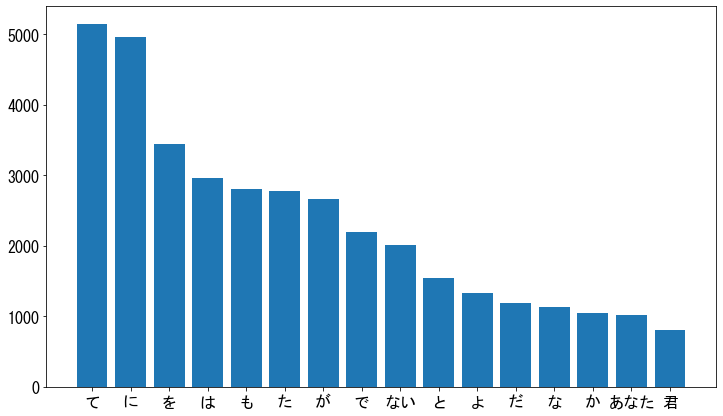

In [19]:
plt.rcParams['font.family'] = "MS Gothic"
plt.rcParams["font.size"] = 16
plt.figure(figsize = (12,7))
plt.bar(df_count_miss.iloc[:c,:]["word"], df_count_miss.iloc[:c,:]["count"])
plt.savefig("word_g1.png")

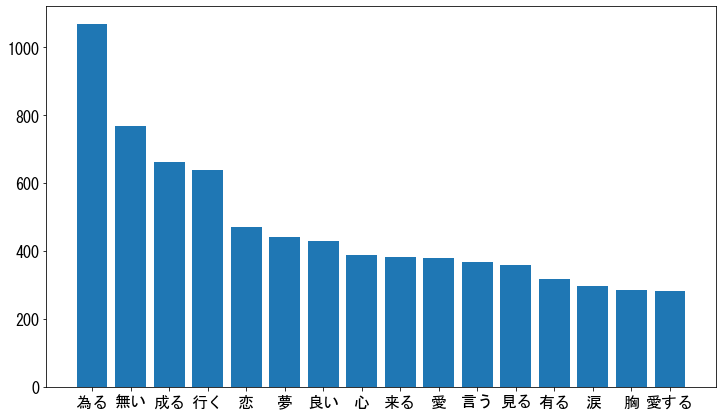

In [18]:
plt.rcParams['font.family'] = "MS Gothic"
plt.rcParams["font.size"] = 16
plt.figure(figsize = (12,7))
plt.bar(df_count.iloc[:c,:]["word"], df_count.iloc[:c,:]["count"])
plt.savefig("word_g2.png")